# A simple Neural Network, written in Numpy

## Why?
After finishing an exam i wanted to get back into python and spend a few days relearning and learning something new. After spending a few hours learning the `pytorch` framework, i wrote a simple sequential network with the MNIST dataset.

As my other plans where canceled by catching covid and not being able to stand up, i decided to test my understanding by writing the same type of network again, simply without a framework. In bed. On an IPad. 

I wanted to figure whatever i could about the design and function of the network myself, only looking up other solutions when i couldn't get it myself. This worked about 90% of the time. I struggled with getting the backwards propagation, especially the derivative of the softmax-function, right. In the end, to really understand, i had to do the calculation myself for my specific system. I will go deeper into this later on. In the end i got it to the point, at which including this part won't do any harm. We'll take it!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('error', RuntimeWarning)

# Read Data

We will train this model on the MNIST dataset, which we stored in 2 `csv` files. 
The files are available [here](https://pjreddie.com/projects/mnist-in-csv).

In [3]:
train_data = pd.read_csv('mnist_train.csv')
test_data = pd.read_csv('mnist_test.csv')

#convert to numpy arrays
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()

#seperate x,y data
y_train = train_data[:,0]
x_train = np.delete(train_data, obj=0,axis=1)
y_test = test_data[:,0]
x_test = np.delete(test_data, obj=0,axis=1)

In [4]:
#we will add one pair (x,y) from testing to training data. why will become clear later
y_train = np.append(y_train, y_test[0])
y_test = y_test[1:]

x_train = np.concatenate((x_train, np.expand_dims(x_test[0], axis=0)), axis=0)
x_test = x_test[1:]
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(9998, 784)


Reshaping the Data makes clear, what it represents. 

We understand $y$ to be a vector of labels for the images $x$. The element $y_i$ is the Number $0-9$ which belongs to a $28x28$ pixel greyscale image of the hand drawn digit $x_i$. There are $60000$ such images and labels in the training data alone.

The raw image values need to be normed from $[0,255]$ integers to $[0,1.]$ float values.

Also will the $y$ labels be represented in unit vectors. This conveniently can be interpreted as a discrete Propability Mass Function. For this we need a "One-Hot"-Function.
E.g. the digit $4$ will be represented as $(0,0,0,0,1,0,0,0,0,0)$.

In [5]:
def OneHotRepresentation(arr):
    N_total = arr.shape[0]
    ret_arr = np.zeros((N_total,10))
    for n in range(0,N_total):
        ret_arr[n,arr[n]] = 1
    return ret_arr

In [6]:
#norm x data
x_train = x_train/255
x_test = x_test/255

#base vector representation of y data
y_train_vectors = OneHotRepresentation(y_train)
y_test_vectors = OneHotRepresentation(y_test)

In [7]:
print(f'x_train: (N_images, N_pixels)={x_train.shape}')
print(f'y_train: (N_images)={y_train.shape}')
print(f'y_train_vectors: (N_images)={y_train_vectors.shape}')
print()
print(f'E.g.: the digit {y_train[-1]} has the vector {y_train_vectors[-1]}')

x_train: (N_images, N_pixels)=(60000, 784)
y_train: (N_images)=(60000,)
y_train_vectors: (N_images)=(60000, 10)

E.g.: the digit 2 has the vector [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
#give a (28,28) matrix to plot for a digit x_i
def xIn2d(x):
    return np.reshape(x,(28,28))

(784,)


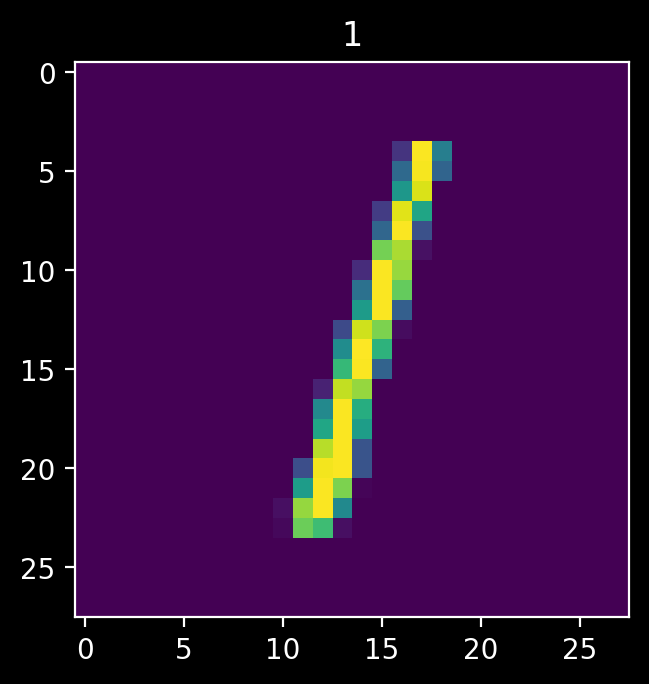

In [9]:
plt.imshow(xIn2d(x_test[0]))
print(x_test[0].shape)
plt.title(f'{y_test[0]}')
plt.show()

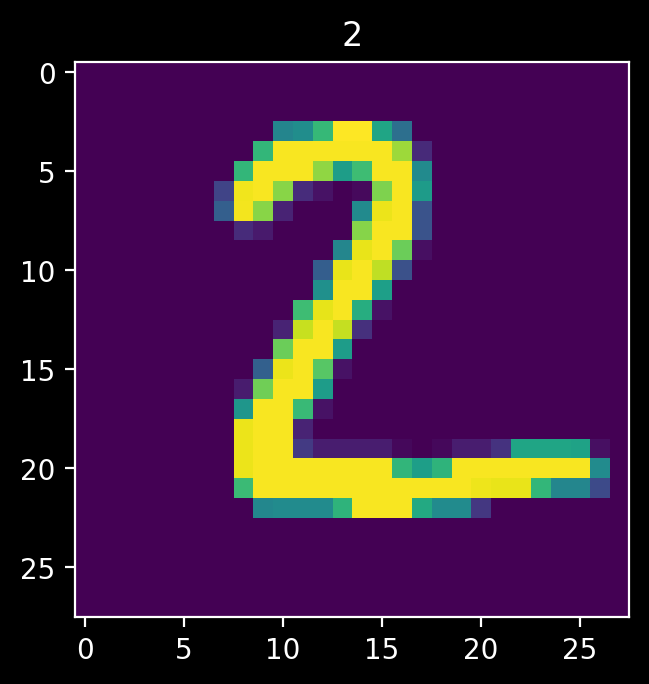

In [10]:
plt.imshow(xIn2d(x_train[-1]))
plt.title(f'{y_train[-1]}')
plt.show()

# Batches

Our Neural Network should process the training data in Batches of 5, this means we need to create a new Matrix, from which we can get single batches. Here becomes clear, why a digit was moved from the testing to the training dataset, as 59999 is prime which makes it rather difficult to find a nice batch size.

- (number of batches, image in batch, pixels of image)

In [11]:
BATCH_SIZE = 5

x_batches = x_train.reshape((-1,BATCH_SIZE,784))
y_batches = y_train_vectors.reshape((-1,BATCH_SIZE,10))
print(x_batches.shape)
print(y_batches.shape)
#print(x_batches[0,0])

(12000, 5, 784)
(12000, 5, 10)


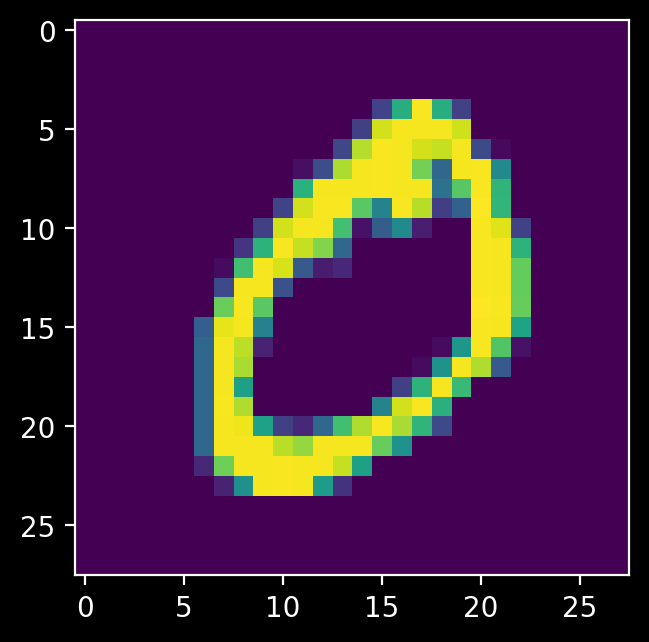

In [12]:
plt.imshow(xIn2d(x_batches[0,0]))

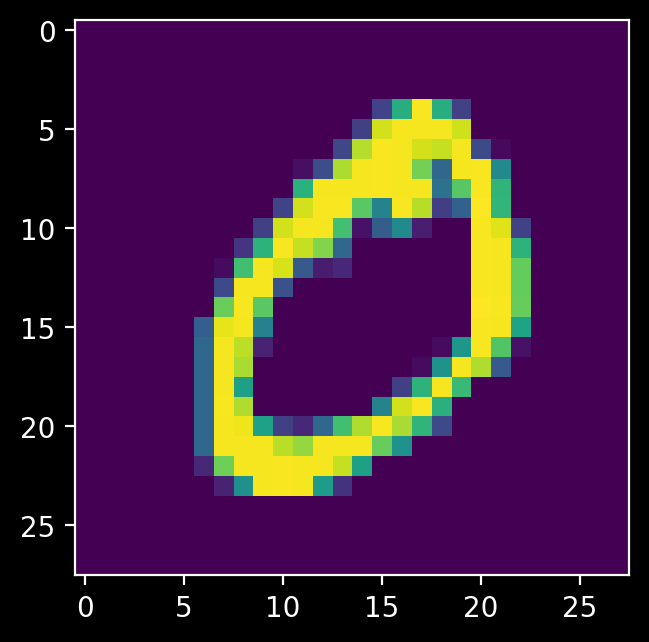

In [13]:
plt.imshow(xIn2d(x_train[0]))

# Neural Network

Disclamer: I know this is not the usual, or evan a good notation. Oh well... :)


Define a Sequential Network with $N=3$ layers, with the final output $y^N$, which will be put into a softmax/Boltzmann-Distribution. The activation function will be ReLu.

The dimensions of $A^1$ are $(in=784, out=m)$ and for $A^i$ as $(n_{in}, m_{out})$. $b^i$ as $($BATCH_SIZE$,(m_{out})$.

- $z^0 = x$
- $y^i = z^i \cdot A^i + b^i$
- $z^{i+} = R(y^i)$
- $z^{N+1} = \frac{e^y}{\sum_k e^{y_k}}$

All these steps applied may be described as a function $f(x,p=\{A,b\})=z^{N+1}$.

The neural network will be evaluated based on the Mean-Square-Error Loss-function:

$L(z^{N+1}, \tilde{y})= \left(z^{N+1} -\tilde{y}\right)^2$


To improve the model the parameters $A_i$ and $b_i$ will be shifted towards the minimum of the loss function after each training batch.

We therefore need to calculate the gradient of $L(\tilde{y},y)$ with respect to each Element of the $A_i$ and $b_i$. Luckily the chain-rule can be applied and Numpy makes element-wise matrix multiplication easy.

In General:

$\frac{\partial L}{\partial A^1} = \frac{\partial L}{\partial z^{N+1}} \cdot \frac{\partial z^{N+1}}{\partial y^N}
\cdot \frac{\partial y^{N}}{\partial z^{N-1}} \cdot \frac{\partial z^{N-1}}{\partial y^{N-2}} \cdot ... \cdot \frac{\partial y^{1}}{\partial A^{1}}
$


In [14]:
#activation function
def R(mat):
    mat[mat<0] = 0
    return mat

#softmax
def softmax(mat):
    mat_ret = np.exp(mat - np.tile(mat.max(axis=1),(mat.shape[1],1)).T)
    #mat_ret = np.exp(mat)
    mat_sum = np.sum(mat_ret,axis=1).reshape(-1,1)
    mat_ret = mat_ret/mat_sum
    return mat_ret

In [15]:
def LossFunction(y, yhat):
    #return (yhat-y)**2
    #one image has a scalar loss, therfore this must return a (5,) vector 
    l2 = (yhat-y)**2
    L_vec = np.sum(l2, axis=1)
    return L_vec/10

def dRdx(mat):
    ret = np.ones(mat.shape)
    ret[mat<0] = 0
    return ret

def gradients(nn, z1, y_control):
    #dL = 2*(nn.z4 - y_control)/10
    #dz = 1 #dZdy(nn.z4,y_control)
    
    dldy3 =  total_dLdy(nn.z4, y_control) #dL*dz 
    dldA3 = (nn.z3.T)@(dldy3) #must be (12,10)
    dldb3 = np.sum(dldy3, axis=0)
    dldy2 = (dldy3@(nn.A3.T))*dRdx(nn.y2) #must end in (5,12)
    dldA2 = (nn.z2.T)@dldy2
    dldb2 = np.sum(dldy2, axis=0)
    dldy1 = (dldy2@(nn.A2.T))*dRdx(nn.y1)
    dldA1 = (z1.T)@dldy1
    dldb1 = np.sum(dldy1, axis=0)
    
    return [dldA1, dldA2, dldA3], [dldb1, dldb2, dldb3]     

Now to talk about the big evil. The derivative of the Loss function/softmax function.
The intuition for this is rather easy when not working with batches. For me personally including another dimension to pay attention to really upped the complexity. 

What worked in the end (for my understanding) is, rather then seperating the derivatives $\frac{\partial L}{\partial z^{N+1}}$ and $\frac{\partial z^{N+1}}{\partial y^N}$, to calculate $\frac{\partial L}{\partial y^N}$ as one, elementwise.

$$ \frac{\partial L_i}{\partial {y^N}_{k,l}} = \sum_{j=1}^{10} l_{i,j,k,l} = \sum_{j=1}^{10} \frac{\partial z_{i,j}}{\partial y_{k,l}} \cdot \frac{2}{10
} \cdot \left( z_{i,j} - \tilde{y_{i,j}} \right)   $$

$$ \frac{\partial z_{i,j}}{\partial y_{k,l}} = 
    \begin{cases}
            0, & \text{if } i\neq k \\
            z_{k,j} - z_{k,j}^2, & \text{if } i=k, j=l \\
            - z_{k,j} \cdot z_{k,l}, & \text{if } i=k, j\neq l \\
    \end{cases}
$$

In [16]:
def dzdy(z, idx_k, idx_j, idx_l):
    if(idx_j == idx_l):
        return z[idx_k, idx_l] - z[idx_k, idx_l]**2
    else:
        return  -z[idx_k, idx_l]*z[idx_k, idx_j]

def elem_dLdy(z, y, idx_k, idx_l):
    elem = 0
    for idx_j in range(y.shape[1]):
        elem += dzdy(z, idx_k, idx_j, idx_l)*(z[idx_k, idx_j] - y[idx_k, idx_j])/5
    return elem                                           

def total_dLdy(z, y):
    dim = z.shape
    dLdy = np.zeros(dim)
    for idx_k in range(dim[0]):
        for idx_l in range(dim[1]):
            dLdy[idx_k, idx_l] = elem_dLdy(z, y, idx_k, idx_l)
    return dLdy
                                                 

Now to define a Network class. Using a class structure might be useful if we later on deside to create multiple instances, say to find the best performing number of cells/dim for our matrices.
(This will be left as an exercise to the reader.)

There are two functions.
- `forward()`: Apply the function $f(x,p=\{A,b\})$.
- `backward()`: The backward propagation, which improves the parameters $A$ and $b$.


Sidenote:
When first writing this i had the typical good praxis for object oriented programming in Java in mind. (Variables controlled by Get/Set functions, for the illusion of security) However it turns out this praxis really isn't a thing in Python.



In [17]:
class Network():
    #constructor
    def __init__(self):
        self.A1 = np.random.rand(784,12) - 0.5
        self.b1 = np.random.rand(1,12) - 0.5
        self.A2 = np.random.rand(12,12) - 0.5
        self.b2 = np.random.rand(1,12) - 0.5
        self.A3 = np.random.rand(12,10) - 0.5
        self.b3 = np.random.rand(1,10) - 0.5
        self.y1 = self.z2 = self.y2 = self.z3 = self.y3 = self.z4 = 0
        
    def forward(self, z1):
        self.y1 = z1@self.A1 + self.b1
        self.z2 = R(self.y1)
        self.y2 = self.z2@self.A2 + self.b2
        self.z3 = R(self.y2)
        self.y3 = self.z3@self.A3 + self.b3
        self.z4 = softmax(self.y3)
    
    def backward(self, z1, y_control, lamb):
        deltaA, deltab = gradients(self, z1, y_control)
        self.A1 = self.A1 - lamb*deltaA[0]
        self.A2 = self.A2 - lamb*deltaA[1]
        self.A3 = self.A3 - lamb*deltaA[2]
        self.b1 = self.b1 - lamb*deltab[0]
        self.b2 = self.b2 - lamb*deltab[1]
        self.b3 = self.b3 - lamb*deltab[2]  

# Training process

The whole training set will be evaluated in several epochs. After each batch the `backward()` function is called.

In [18]:
def training(x_total, y_total, nn, epoch_N=20, lamb_correction=0.001):
    losses = []
    epochs = []
    
    for epoch in range(epoch_N):
        print(epoch)
        lo = 0
        for batch in range(x_total.shape[0]):
            x_current = x_total[batch]
            y_current = y_total[batch]
            
            #calculate prediction
            nn.forward(x_current)
            #calculate loss function
            loss_current = LossFunction(y_current,nn.z4)
            lo = loss_current
            epochs.append(epoch+batch/(x_total.shape[0]))
            #calculate the gradients to improve the nn parameters
            nn.backward(x_current, y_current, lamb_correction)
        losses.append(lo)
            
    return np.array(epochs), np.array(losses)

In [19]:
network = Network()
ep, lo = training(x_batches, y_batches, network, 10, 0.001)

0
1
2
3
4
5
6
7
8
9


# Evaluation

Lets plot the mean loss function per epoch to see how the network improves and wether it would be useful to in/decrease the number of epochs. 

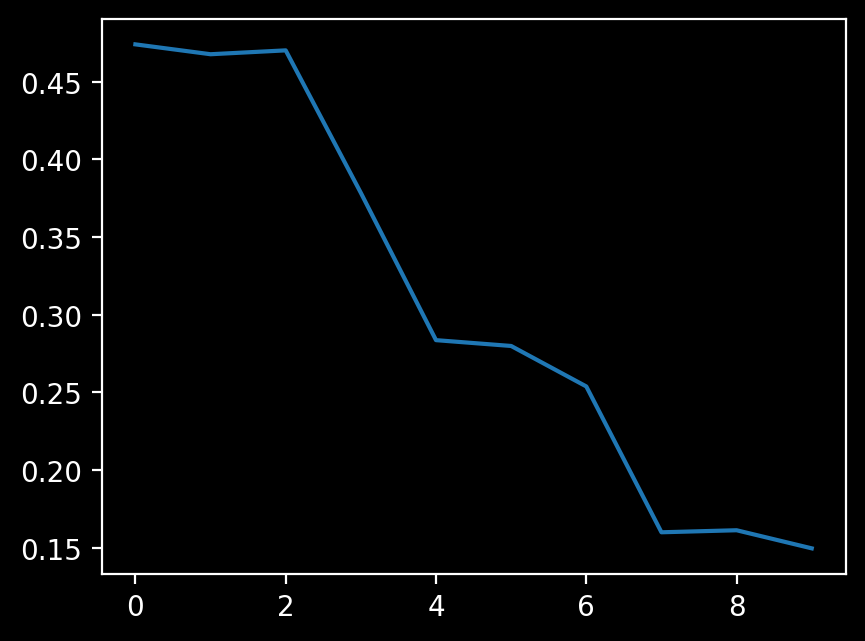

In [20]:
plt.plot(np.sum(lo,axis=1))

We can evaluate the success rate by testing the test data we set aside in the beginning and comparing to the given label. (We actually don't need to create batches, only add a dimension. Batches simply make printing later easier)

In [21]:
x_test_batches = (x_test[:-3]).reshape((-1,BATCH_SIZE,784))
y_test_batches = (y_test[:-3]).reshape((-1,BATCH_SIZE))

#x_test_batches = (x_test).reshape((-1,1,784))
#y_test_batches = (y_test).reshape((-1,1))


Ntotal = y_test[:-3].shape[0]
Nright = 0
for batch in range(x_test_batches.shape[0]):
    network.forward(x_test_batches[batch])
    pred_batch = network.z4
    real_batch = y_test_batches[batch]
    for idx in range(x_test_batches.shape[1]):
        pred_num = np.argmax(pred_batch[idx])
        real_num = real_batch[idx]
        if(pred_num == real_num):
            Nright += 1
            
ratio = Nright/Ntotal
print(f'Precission: {100*ratio:.5}%')  

Precission: 78.039%


Finally lets look at some images!
We simply choose a random batch from our test data.

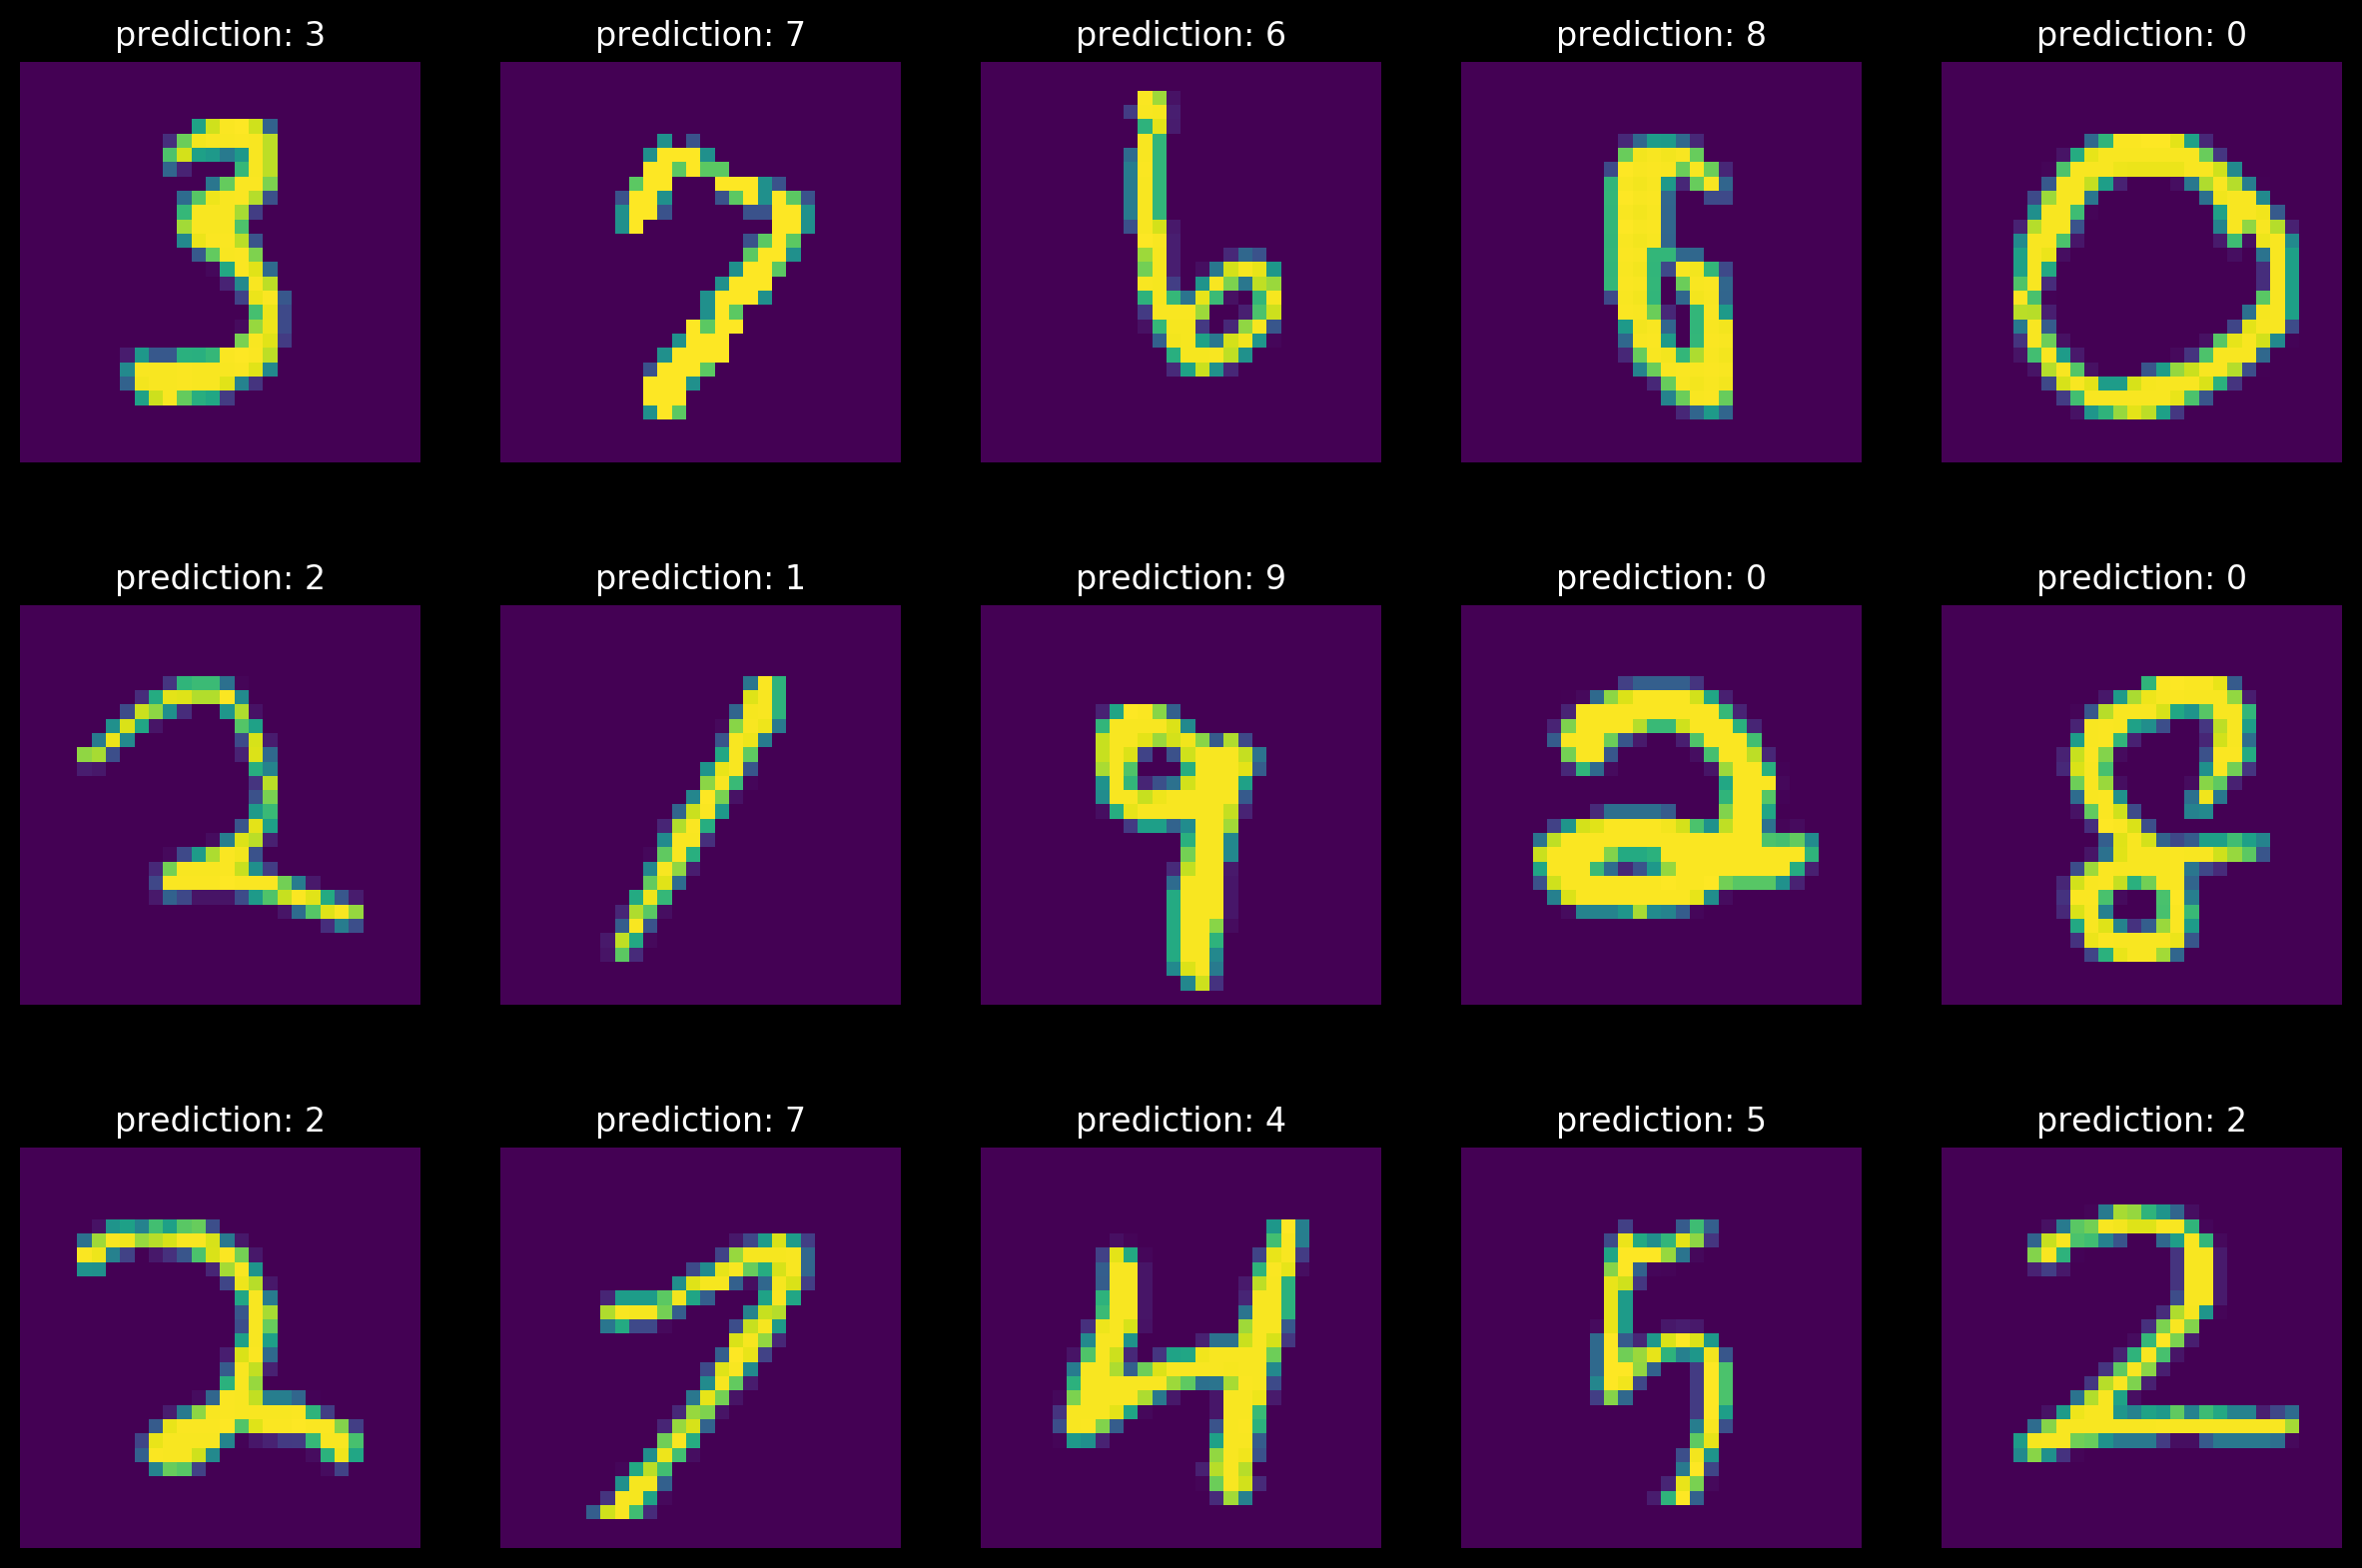

In [22]:
fig, ax = plt.subplots( ncols=5, nrows=3)
fig.set_size_inches((15,10))

           
for p in range(3):
    x_print = x_test_batches[np.random.randint(x_test_batches.shape[0])]
    network.forward(x_print)
    pred_batch = network.z4
    for q in range(x_test_batches.shape[1]):
        ax[p,q].imshow(xIn2d(x_print[q]))
        ax[p,q].set_title(f'prediction: {np.argmax(pred_batch[q])}')
        ax[p,q].axis('off')